## BlackSheep Cookbook Exploration

The Black Sheep Analysis allows researchers to find trends in abnormal protein enrichment among patients in CPTAC datasets. In this Cookbook, we will go through the steps needed to perform a full Black Sheep Analysis.

### Step 1a: Import Dependencies
First, import the necessary dependencies and load cptac data.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cptac
import binarization_functions as bf
import blackSheepCPTACmoduleCopy as blsh
import gseapy as gp
from gseapy.plot import barplot, heatmap, dotplot

## Step 1b: Load Data and Choose Omics Table
For this analysis, we will be looking at results across the proteomics, transcriptomics, and phosphoproteomics tables.

In [31]:
cptac.download(dataset='endometrial')

All files already downloaded and correct.


True

In [32]:
en = cptac.Endometrial()
proteomics = en.get_proteomics()
transcriptomics = en.get_transcriptomics()
clinical = en.get_clinical()

In [33]:
#Append Genomics_subtype and MSI_status to clinical table
df= en.get_derived_molecular()
clinical['MSI_status'] = df['MSI_status']
clinical['Genomics_subtype'] = df['Genomics_subtype']

## Step 2: Determine what attributes you would like to A/B test. 
For this analysis, we will iteratively go through the various columns in the clinical dataset, to determine if any of them have trends within them for protein enrichment.

In [34]:
#Create a copy of the original Clinical DataFrame and drop irrelevant columns.
annotations = pd.DataFrame(clinical.copy())
annotations = annotations.drop(['Patient_ID', 
                                'Treatment_naive', 
                                'Tumor_purity', 
                                'Gender', 
                                'Tumor_Site_Other'], axis=1)

## Step 2a: Binarize column values

In [35]:
tumor_map = {'Tumor':'Normal_Tumor', 
             'Adjacent_normal':'Other_tumor', 
             'Enriched_normal':'Other_tumor', 
             'Myometrium_normal':'Other_tumor'}

annotations['Proteomics_Tumor_Normal'] = bf.binarizeCategorical(clinical, 
                                                                'Proteomics_Tumor_Normal', 
                                                                tumor_map)

In [36]:
country_map = {'United States':'US', 
               'Ukraine':'Other', 
               'Other_specify':'Other', 
               'Poland':'Other'}

annotations['Country'] = bf.binarizeCategorical(clinical, 
                                                'Country', 
                                                country_map)

In [37]:
annotations['BMI'] = bf.binarizeRange(clinical, 'BMI', 18, 25, 
                                      'Healthy', 'Unhealthy')

annotations['Age'] = bf.binarizeCutOff(clinical, 'Age', 
                                       60.0, 'Old', 'Young')

In [38]:
FIGO_map = {'FIGO grade 1':'Low_grade', 
            'FIGO grade 2':'High_grade', 
            'FIGO grade 3':'High_grade'}

annotations['Histologic_Grade_FIGO'] = bf.binarizeCategorical(clinical, 
                                                              'Histologic_Grade_FIGO', 
                                                              FIGO_map)

In [39]:
Myo_map = {'under 50 %':'under_50%', 
           '50 % or more': '50%_or_more', 
           'Not identified': 'under_50%'}

annotations['Myometrial_invasion_Specify'] = bf.binarizeCategorical(clinical, 
                                                                    'Myometrial_invasion_Specify', 
                                                                    Myo_map)

In [40]:
path_tumor_map = {'pT1a (FIGO IA)':'Not_FIGO_III', 
            'pT1b (FIGO IB)':'Not_FIGO_III', 
            'pT2 (FIGO II)':'Not_FIGO_III', 
            'pT1 (FIGO I)':'Not_FIGO_III', 
            'pT3a (FIGO IIIA)':'FIGO_III', 
            'pT3b (FIGO IIIB)':'FIGO_III'}

annotations['Path_Stage_Primary_Tumor-pT'] = bf.binarizeCategorical(clinical, 
                                                                    'Path_Stage_Primary_Tumor-pT', 
                                                                    path_tumor_map)

In [41]:
path_lymph_map = {'pN0':'Not_FIGO_III', 
                  'pNX':'Not_FIGO_III', 
                  'pN1 (FIGO IIIC1)':'FIGO_III', 
                  'pN2 (FIGO IIIC2)':'FIGO_III'}

annotations['Path_Stage_Reg_Lymph_Nodes-pN'] = bf.binarizeCategorical(clinical, 
                                                                      'Path_Stage_Reg_Lymph_Nodes-pN', 
                                                                      path_lymph_map)

In [42]:
clin_stage_map = {'cM0':'cM0_or_cM1', 
                  'cM1':'cM0_or_cM1', 
                  'Staging Incomplete':'Staging_Incomplete'}

annotations['Clin_Stage_Dist_Mets-cM'] = bf.binarizeCategorical(clinical, 
                                                                'Clin_Stage_Dist_Mets-cM', 
                                                                clin_stage_map)

In [43]:
path_stage_map = {'Staging Incomplete': 'No_distant_metastasis', 
                  'No pathologic evidence of distant metastasis':'No_distant_metastasis', 
                  'pM1':'Distant_Metastasis'}

annotations['Path_Stage_Dist_Mets-pM'] = bf.binarizeCategorical(clinical, 
                                                                'Path_Stage_Dist_Mets-pM', 
                                                                path_stage_map)

In [44]:
tumor_stage_map = {'Stage I':'Stage_I_or_II', 
                   'Stage II':'Stage_I_or_II', 
                   'Stage III':'Stage_III_or_IV', 
                   'Stage IV':'Stage_III_or_IV'}

annotations['tumor_Stage-Pathological'] = bf.binarizeCategorical(clinical, 
                                                               'tumor_Stage-Pathological', 
                                                               tumor_stage_map)

In [45]:
FIGO_stage_map = {'IA':'I_or_II', 
                  'IB':'I_or_II', 
                  'II':'I_or_II', 
                  'IIIA':'III_or_IV', 
                  'IIIC1':'III_or_IV', 
                  'IVB':'III_or_IV', 
                  'IIIC2':'III_or_IV', 
                  'IIIB':'III_or_IV'}

annotations['FIGO_stage'] = bf.binarizeCategorical(clinical, 
                                                   'FIGO_stage', 
                                                   FIGO_stage_map)

In [46]:
diabetes_map = {'No':'No', 
                'Yes':'Yes', 
                'Unknown':'No'}

annotations['Diabetes'] = bf.binarizeCategorical(clinical, 
                                                 'Diabetes', 
                                                 diabetes_map)

In [47]:
race_map = {'White':'White', 
            'Black or African American':'Not_White', 
            'Asian':'Not_White', 
            'Not Reported':'Not_White'}

annotations['Race'] = bf.binarizeCategorical(clinical, 
                                             'Race', 
                                             race_map)

In [48]:
ethnicity_map = {'Not-Hispanic or Latino':'Not_Hispanic', 
                 'Not reported':'Not_Hispanic', 
                 'Hispanic or Latino':'Hispanic'}

annotations['Ethnicity'] = bf.binarizeCategorical(clinical, 
                                                  'Ethnicity', 
                                                  ethnicity_map)

In [49]:
tumor_site_map = {'Other, specify':'Not_Anterior', 
                  'Anterior endometrium':'Anterior', 
                  'Posterior endometrium':'Not_Anterior'}

annotations['Tumor_Site'] = bf.binarizeCategorical(clinical, 
                                                   'Tumor_Site', 
                                                   tumor_site_map)

In [50]:
annotations['Tumor_Size_cm'] = bf.binarizeCutOff(clinical, 
                                                'Tumor_Size_cm', 4.0, 
                                                'Large_tumor', 
                                                'Small_tumor')

In [51]:
num_pregnancies_map = {2:'Less_than_3', 
                       1:'Less_than_3', 
                       'None':'Less_than_3', 
                       None:'Less_than_3', 
                       3:'3_or_more', 
                       '4 or more':'3_or_more'}

annotations['Num_full_term_pregnancies'] = bf.binarizeCategorical(clinical, 
                                                                  'Num_full_term_pregnancies', 
                                                                  num_pregnancies_map)

In [52]:
genomics_map = {'MSI-H':'MSI-H', 
                'CNV_low':'Other_subtype', 
                'CNV_high':'Other_subtype', 
                'POLE':'Other_subtype'}

annotations['Genomics_subtype'] = bf.binarizeCategorical(clinical, 
                                                         'Genomics_subtype', 
                                                         genomics_map)

## Step 3: Perform outliers analysis

In [53]:
outliers_prot = blsh.make_outliers_table(proteomics, iqrs=1.5, 
                                         up_or_down='up', 
                                         aggregate=False, 
                                         frac_table=False)

C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\numpy\lib\nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


## Step 4: Wrap your A/B test into the outliers analysis, and create a table
First for proteomics, and then phosphoproteomics.

In [54]:
results_prot = blsh.compare_groups_outliers(outliers_prot, 
                                            annotations)

No rows had outliers in at least 0.3 of Proteomics_Tumor_Normal Normal_Tumor samples
Testing 14 rows for enrichment in Proteomics_Tumor_Normal Other_tumor samples
No rows had outliers in at least 0.3 of Country Other samples
No rows had outliers in at least 0.3 of Country US samples
Testing 2 rows for enrichment in Histologic_Grade_FIGO High_grade samples
Testing 1 rows for enrichment in Histologic_Grade_FIGO Low_grade samples
No rows had outliers in at least 0.3 of Myometrial_invasion_Specify under_50% samples
Testing 7 rows for enrichment in Myometrial_invasion_Specify 50%_or_more samples
No rows had outliers in at least 0.3 of Histologic_type Endometrioid samples
Testing 626 rows for enrichment in Histologic_type Serous samples
No rows had outliers in at least 0.3 of Path_Stage_Primary_Tumor-pT Not_FIGO_III samples
Testing 241 rows for enrichment in Path_Stage_Primary_Tumor-pT FIGO_III samples
No rows had outliers in at least 0.3 of Path_Stage_Reg_Lymph_Nodes-pN Not_FIGO_III samples

Many of the output values from compare_group_outliers are NaN, so here we will get rid of the NaN values for visualization purposes.

In [55]:
results_prot = results_prot.dropna(axis=0, how='all')

In [56]:
print("TESTING FOR PROTEOMICS:")
sig_cols = []
for col in results_prot.columns:
    sig_col = bf.significantEnrichments(results_prot, col, 0.01)
    if sig_col is not None and len(sig_col) > 5:
        sig_cols.append(sig_col)
    else:
        results_prot = results_prot.drop(col, axis=1)

TESTING FOR PROTEOMICS:
14 significant protein enrichments in Proteomics_Tumor_Normal_Other_tumor

2 significant protein enrichments in Myometrial_invasion_Specify_50%_or_more

412 significant protein enrichments in Histologic_type_Serous

1 significant protein enrichment in Path_Stage_Reg_Lymph_Nodes-pN_FIGO_III:

8 significant protein enrichments in LVSI_1.0

2 significant protein enrichments in Age_Young

3 significant protein enrichments in Tumor_Site_Anterior

2 significant protein enrichments in Tumor_Focality_Multifocal

3 significant protein enrichments in MSI_status_MSI-H

3 significant protein enrichments in Genomics_subtype_MSI-H



## Step 5: Visualize these enrichments

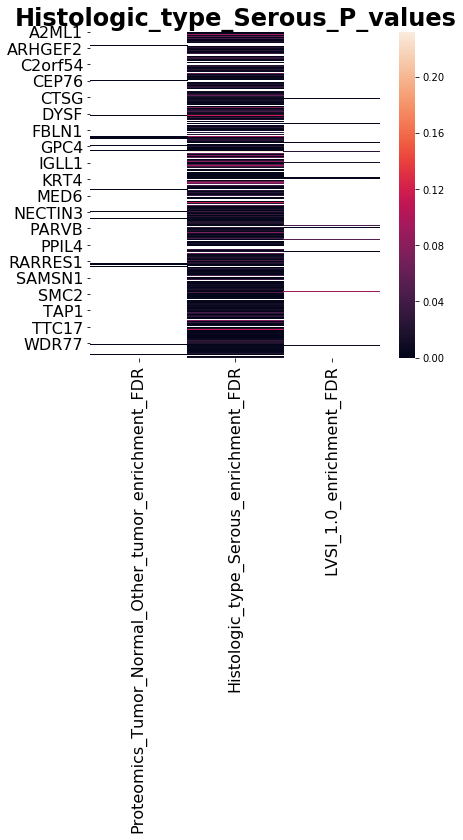

In [57]:
sns.heatmap(results_prot)
plt.show()

## Step 6: Determine significant enrichments, and link with cancer drug database.

In [58]:
for col in sig_cols:
    col_name = col.columns[0]
    gene_name_list = list(col.index)
    enrichment = gp.enrichr(gene_list = gene_name_list, 
                            description=col_name, 
                            gene_sets='KEGG_2019_Human',
                            outdir='test/endometrial')
    print(enrichment.res2d)
    barplot(enrichment.res2d, title=col_name)

2019-08-13 13:08:31,684 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


           Gene_set                                             Term Overlap  \
0   KEGG_2019_Human                                      Endocytosis   2/244   
1   KEGG_2019_Human                    Glycosaminoglycan degradation    1/19   
2   KEGG_2019_Human         Pentose and glucuronate interconversions    1/34   
3   KEGG_2019_Human                                      Ferroptosis    1/40   
4   KEGG_2019_Human             Porphyrin and chlorophyll metabolism    1/42   
5   KEGG_2019_Human                               Mineral absorption    1/51   
6   KEGG_2019_Human            Regulation of lipolysis in adipocytes    1/55   
7   KEGG_2019_Human                  Fc epsilon RI signaling pathway    1/68   
8   KEGG_2019_Human                  Adipocytokine signaling pathway    1/69   
9   KEGG_2019_Human                           ErbB signaling pathway    1/85   
10  KEGG_2019_Human                           GnRH signaling pathway    1/93   
11  KEGG_2019_Human                T cel

[159 rows x 10 columns]


2019-08-13 13:08:37,860 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


          Gene_set                                      Term Overlap  \
0  KEGG_2019_Human   Glyoxylate and dicarboxylate metabolism    1/30   
1  KEGG_2019_Human  Glycine, serine and threonine metabolism    1/40   
2  KEGG_2019_Human                             RNA transport   1/165   

    P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0  0.011939               1.0            0                     0   83.333333   
1  0.015891               1.0            0                     0   62.500000   
2  0.064136               1.0            0                     0   15.151515   

   Combined Score Genes  
0      368.994341  GLDC  
1      258.874854  GLDC  
2       41.617414  XPO5  
